# 📌 图像分类基础概念

图像分类是计算机视觉中最基础且广泛应用的任务之一，其目标是**根据图像内容自动判断其所属的预定义类别**。例如，在电力作业安全监督场景中，我们可以训练一个模型，自动判断一张现场照片是否“合规”（如人员正确佩戴安全帽、穿戴绝缘服等），从而实现高效、自动化的安全巡检。

### 🔍 典型流程
一个完整的图像分类项目通常包含以下几个关键环节：

1. **数据准备**  
   - 收集并清洗图像数据，剔除模糊、无关或标注错误的样本；
   - 按类别组织数据（如文件夹结构或标签文件），确保类别定义清晰、无歧义。

2. **数据增强（Data Augmentation）**  
   - 通过对原始图像进行旋转、裁剪、亮度调整等操作，人工扩展训练数据，提升模型泛化能力，防止过拟合。

3. **模型选择与训练**  
   - 选用合适的深度学习架构（如 ResNet、EfficientNet、Vision Transformer 等）；
   - 在训练集上学习图像特征与类别之间的映射关系，并在验证集上评估性能。

4. **模型评估**  
   - 使用准确率（Accuracy）、精确率（Precision）、召回率（Recall）、F1 分数等指标衡量模型效果；
   - 特别关注**关键类别**（如“不合规”）的识别能力，在安全场景中，漏报（False Negative）往往比误报代价更高。

5. **模型部署**  
   - 将训练好的模型封装为服务，接收图像输入（通常为 base64 编码），返回分类结果与置信度；
   - 在实际系统中实现端到端的自动化判断。

## 1.1 工具包导入

In [1]:
!pip install timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [2]:
import torch
torch.manual_seed(0)  # 设置随机种子以确保结果可重复
torch.backends.cudnn.deterministic = False  # 允许某些非确定性操作，以提高训练速度
torch.backends.cudnn.benchmark = True  # 允许CUDNN自动寻找最优的算法，以提高训练速度

import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset
from pathlib import Path
import timm  # 提供了大量的预训练模型
import time

import pandas as pd
import numpy as np
import cv2
from PIL import Image
from tqdm import tqdm_notebook  # 用于显示训练和验证过程的进度条
import timm

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

## 1.2 定义计算平均指标和显示进度的类
`AverageMeter`类用于计算并存储平均值和当前值，`ProgressMeter`类用于显示训练和验证过程的进度。


In [3]:
# 定义一个计算并存储平均值和当前值的类
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


# 定义一个显示进度的类
class ProgressMeter(object):
    def __init__(self, num_batches, *meters):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = ""

    def pr2int(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'

## 1.3 定义数据加载类
`FFDIDataset`类用于加载数据集。`__init__`方法用于初始化数据集，`__getitem__`方法用于获取数据集中的样本，`__len__`方法用于获取数据集的长度。
`__init__`方法接受`img_path`和`img_label`作为输入，`transform`参数用于对图像进行预处理。

In [4]:
class FFDIDataset(Dataset):
    def __init__(self, img_path, img_label, transform=None):
        self.img_path = img_path
        self.img_label = img_label
        
        if transform is not None:
            self.transform = transform
        else:
            self.transform = None
    
    def __getitem__(self, index):
        img = Image.open(self.img_path[index]).convert('RGB')
        
        if self.transform is not None:
            img = self.transform(img)
        
        return img, torch.from_numpy(np.array(self.img_label[index]))
    
    def __len__(self):
        return len(self.img_path)

## 1.4 定义数据加载和预处理
这一部分定义了数据加载和预处理的过程。首先，读取训练和验证数据的标签文件，然后生成训练和验证数据的路径。接着，定义了训练和验证数据加载器，使用`torch.utils.data.DataLoader`加载数据集，并对图像进行预处理。

此外对于训练集还使用了随机数据增强操作来动态扩充数据集。

In [5]:
# 读取训练和验证数据的标签文件
trainset_path = Path("/kaggle/input/intel-image-classification/seg_train/seg_train")
image_paths, image_labels = [], []
for path in trainset_path.glob("**/*.jpg"):
    image_paths.append(str(path))
    image_labels.append(str(path.parent.stem))

# 使用label encoder将字符串类转为数值类型
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
image_labels = encoder.fit_transform(image_labels)

In [6]:
set(image_labels)

{0, 1, 2, 3, 4, 5}

In [7]:
# 读取测试数据的标签文件
testset_path = Path("/kaggle/input/intel-image-classification/seg_test/seg_test")
test_image_paths, test_image_labels = [], []
for path in testset_path.glob("**/*.jpg"):
    test_image_paths.append(str(path))
    test_image_labels.append(str(path.parent.stem))

# 使用label encoder将字符串类转为数值类型
from sklearn.preprocessing import LabelEncoder

test_image_labels = encoder.transform(test_image_labels)

In [8]:
bs_value = 32  # 批次大小：平衡训练速度与显存占用，32 是常用值

# ==============================
# 训练集数据增强策略（针对电力作业图像优化）
# ==============================
train_set_transform = transforms.Compose([
    # 1. 统一输入尺寸：确保所有图像缩放到相同分辨率
    #    注意：Resize((256, 256)) 会拉伸图像，若需保持宽高比，可改用 Resize(256) + CenterCrop(224)
    transforms.Resize((256, 256)),
    
    # 2. 【核心增强】RandAugment：自动组合多种增强操作，适合分类任务
    #    - num_ops=2：每次应用 2 种增强操作
    #    - magnitude=9：增强强度（0~30），9 为中等偏强，适用于安全场景多样性需求
    transforms.RandAugment(num_ops=2, magnitude=9),
    
    # ==============================
    # 【可选增强】以下为补充增强方法（可按需取消注释）
    # ==============================
    
    # 随机水平翻转（适用于电力作业场景，人员左右对称通常合理）
    # transforms.RandomHorizontalFlip(p=0.5),
    
    # 随机旋转（±10度）：模拟拍摄角度轻微偏移
    # transforms.RandomRotation(degrees=10),
    
    # 随机裁剪并缩放回原尺寸：提升模型对局部特征的鲁棒性
    # transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    
    # 颜色抖动：模拟光照变化（电力现场光照条件复杂）
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.05),
    
    # 随机擦除（CutOut）：提升对局部遮挡的鲁棒性（如安全帽被遮挡）
    # transforms.RandomErasing(p=0.3, scale=(0.02, 0.1), ratio=(0.3, 3.3), value=0, inplace=False),
    
    # 3. 转换为 PyTorch 张量（HWC → CHW，像素值 [0,255] → [0,1]）
    transforms.ToTensor(),
    
    # 4. 归一化：使用 ImageNet 统计值，便于迁移学习（若使用预训练模型）
    #    mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# ==============================
# 训练数据加载器
# ==============================
train_loader = torch.utils.data.DataLoader(
    FFDIDataset(image_paths, image_labels, train_set_transform),
    batch_size=bs_value,
    shuffle=True,          # 每个 epoch 打乱数据，防止过拟合
    num_workers=4,         # 多进程加载数据（根据 CPU 核心数调整）
    pin_memory=True        # 锁页内存，加速 GPU 数据传输
)

In [9]:
for image, label in train_loader:
    print(image.shape)
    print(label)
    break

torch.Size([32, 3, 256, 256])
tensor([5, 5, 4, 1, 2, 2, 0, 1, 0, 0, 1, 4, 1, 2, 0, 3, 0, 0, 4, 5, 1, 3, 1, 0,
        0, 0, 0, 4, 3, 4, 4, 2])


In [10]:
# 定义验证数据加载器
val_set_transform = transforms.Compose([
                    transforms.Resize((256, 256)),  # 调整图像大小
                    transforms.ToTensor(),  # 转换为张量
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # 归一化
                ])
val_loader = torch.utils.data.DataLoader(
    FFDIDataset(test_image_paths, test_image_labels, val_set_transform), batch_size=bs_value, shuffle=False, num_workers=4, pin_memory=True
)

## 1.5 定义模型
使用`timm`库提供的`create_model`函数创建一个预训练的EfficientNet模型，并将其移动到GPU上。`timm`是一个提供了大量预训练模型的库，可以方便地使用各种模型进行训练和预测。更多信息可以访问[timm GitHub](https://github.com/huggingface/pytorch-image-models)。

In [11]:
model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=len(set(image_labels)))
model.cuda()

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2

## 1.6 定义训练、验证和预测函数
这一部分定义了训练、验证和预测的函数，包括`train`、`validate`和`predict`函数。这些函数用于训练模型、验证模型和预测测试集的结果。

In [12]:
# 定义验证过程
def validate(val_loader, model, criterion):
    batch_time = AverageMeter('Time', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    progress = ProgressMeter(len(val_loader), batch_time, losses, top1)

    # 切换到评估模式
    model.eval()

    with torch.no_grad():
        end = time.time()
        for i, (input, target) in tqdm_notebook(enumerate(val_loader), total=len(val_loader)):
            input = input.cuda()
            target = target.cuda()

            # 计算输出
            output = model(input)
            loss = criterion(output, target)

            # 计算准确度并记录损失
            acc = (output.argmax(1).view(-1) == target.float().view(-1)).float().mean() * 100
            losses.update(loss.item(), input.size(0))
            top1.update(acc, input.size(0))
            # 计算耗时
            batch_time.update(time.time() - end)
            end = time.time()

        # TODO: 这也应该用ProgressMeter来做
        print(' * Acc@1 {top1.avg:.3f}'
              .format(top1=top1))
        return top1


# 定义预测过程
def predict(test_loader, model, tta=10):
    # 切换到评估模式
    model.eval()

    test_pred_tta = None
    for _ in range(tta):
        test_pred = []
        with torch.no_grad():
            end = time.time()
            for i, (input, target) in tqdm_notebook(enumerate(test_loader), total=len(test_loader)):
                input = input.cuda()
                target = target.cuda()

                # 计算输出
                output = model(input)
                output = F.softmax(output, dim=1)
                output = output.data.cpu().numpy()

                test_pred.append(output)
        test_pred = np.vstack(test_pred)

        if test_pred_tta is None:
            test_pred_tta = test_pred
        else:
            test_pred_tta += test_pred

    return test_pred_tta


# 定义训练过程
def train(train_loader, model, criterion, optimizer, epoch):
    batch_time = AverageMeter('Time', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    progress = ProgressMeter(len(train_loader), batch_time, losses, top1)

    # 切换到训练模式
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):
        input = input.cuda(non_blocking=True)
        target = target.cuda(non_blocking=True)

        # 计算输出
        output = model(input)
        loss = criterion(output, target)

        # 记录损失
        losses.update(loss.item(), input.size(0))

        # 计算准确度
        acc = (output.argmax(1).view(-1) == target.float().view(-1)).float().mean() * 100
        top1.update(acc, input.size(0))

        # 计算梯度并执行优化步骤
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 计算耗时
        batch_time.update(time.time() - end)
        end = time.time()

        if i % 100 == 0:
            progress.pr2int(i)

## 1.7 定义损失函数和优化器
这一部分定义了损失函数、优化器和学习率调度器。`nn.CrossEntropyLoss`用于计算交叉熵损失，`torch.optim.Adam`用于执行Adam优化算法，`optim.lr_scheduler.StepLR`用于调整学习率。

交叉熵损失函数（Cross-Entropy Loss）是图像分类等任务中最常用的损失函数之一，用于衡量模型预测的概率分布与真实标签之间的差异。

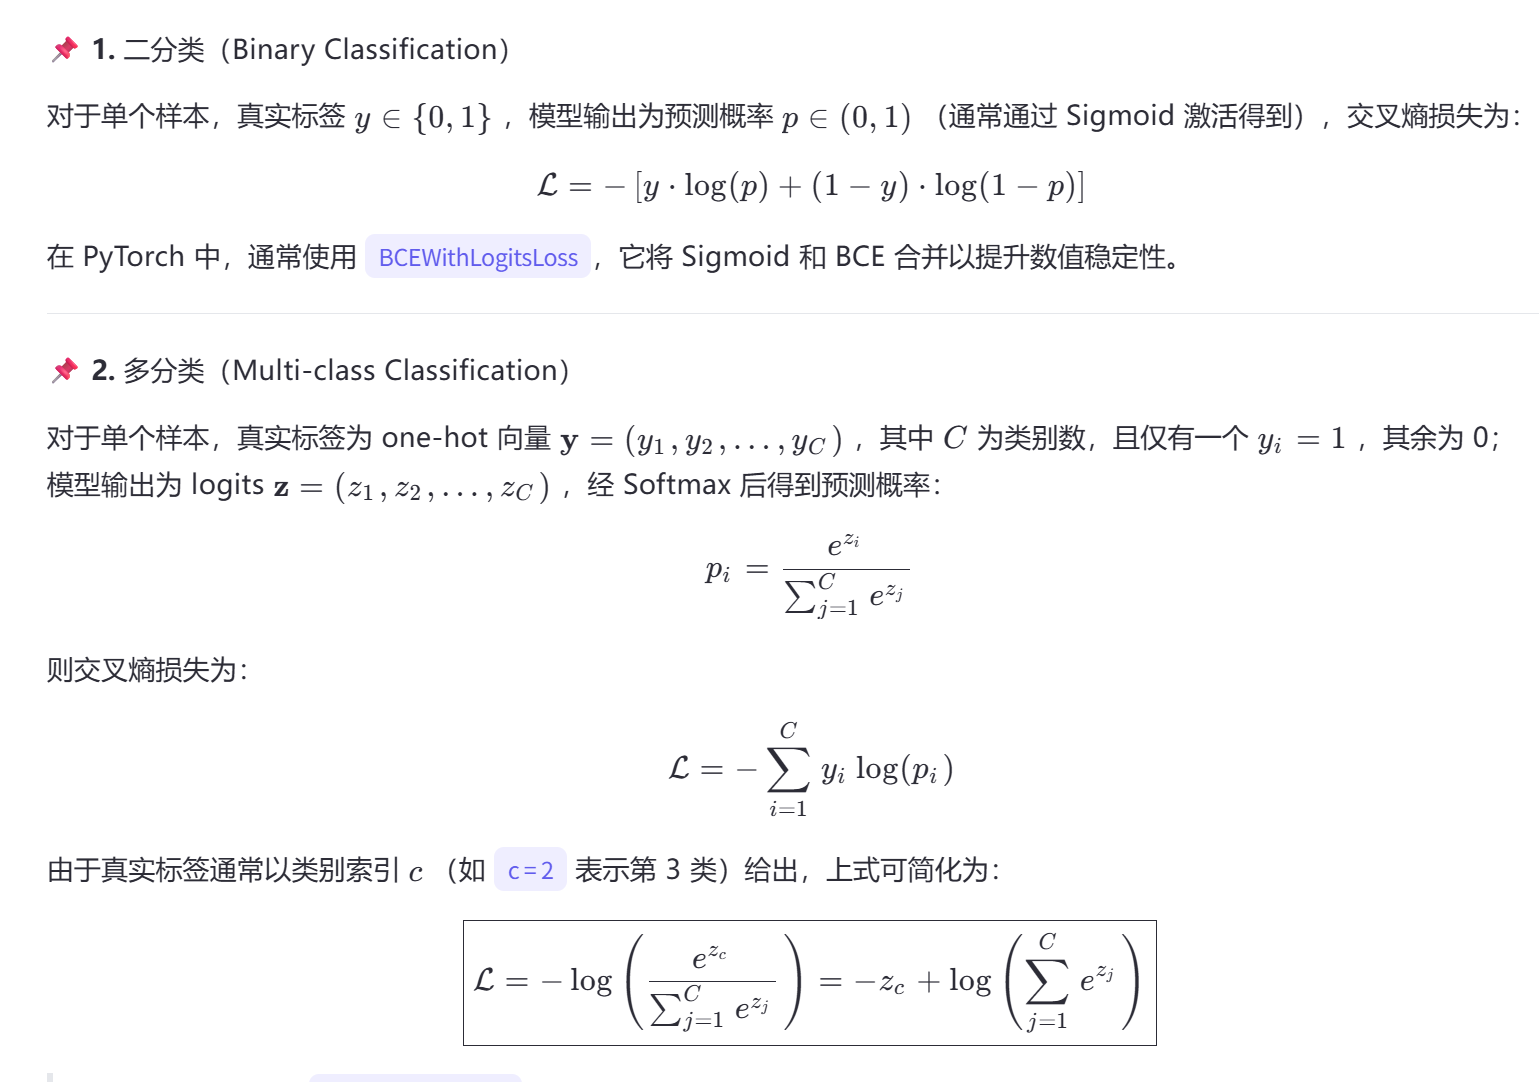

In [13]:
epoch_num = 10  # 设置训练的总轮数
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), 0.005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.85)  # 学习率调度器
best_acc = 0.0  # 初始化最佳准确度

## 1.8 训练模型


In [14]:
# 训练和验证模型
for epoch in range(epoch_num):
    scheduler.step()  # 更新学习率
    print('Epoch: ', epoch)

    train(train_loader, model, criterion, optimizer, epoch)  # 训练模型
    val_acc = validate(val_loader, model, criterion)  #
    # 验证模型
    if val_acc.avg.item() > best_acc:
        best_acc = round(val_acc.avg.item(), 2)
        torch.save(model.state_dict(), f'./model_{best_acc}.pt')  # 保存表现更好的模型

# 整个保存最终模型
torch.save(model, "last.pt")

Epoch:  0


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


[  0/439]	Time  3.310 ( 3.310)	Loss 3.7468e+00 (3.7468e+00)	Acc@1  15.62 ( 15.62)
[100/439]	Time  0.130 ( 0.155)	Loss 7.3238e-01 (1.6975e+00)	Acc@1  75.00 ( 50.84)
[200/439]	Time  0.112 ( 0.140)	Loss 5.7170e-01 (1.2605e+00)	Acc@1  75.00 ( 60.81)
[300/439]	Time  0.128 ( 0.135)	Loss 5.8441e-01 (1.1019e+00)	Acc@1  78.12 ( 65.11)
[400/439]	Time  0.122 ( 0.132)	Loss 5.0859e-01 (1.0081e+00)	Acc@1  78.12 ( 67.35)


/tmp/ipykernel_19/632448275.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, (input, target) in tqdm_notebook(enumerate(val_loader), total=len(val_loader)):


  0%|          | 0/94 [00:00<?, ?it/s]

 * Acc@1 85.433
Epoch:  1
[  0/439]	Time  0.538 ( 0.538)	Loss 4.4502e-01 (4.4502e-01)	Acc@1  84.38 ( 84.38)
[100/439]	Time  0.130 ( 0.128)	Loss 8.4085e-01 (5.5576e-01)	Acc@1  78.12 ( 80.35)
[200/439]	Time  0.121 ( 0.126)	Loss 5.6780e-01 (5.4023e-01)	Acc@1  78.12 ( 81.00)
[300/439]	Time  0.119 ( 0.125)	Loss 4.6768e-01 (5.2721e-01)	Acc@1  78.12 ( 81.16)
[400/439]	Time  0.122 ( 0.125)	Loss 6.0271e-01 (5.3284e-01)	Acc@1  81.25 ( 81.53)


  0%|          | 0/94 [00:00<?, ?it/s]

 * Acc@1 88.833
Epoch:  2
[  0/439]	Time  0.517 ( 0.517)	Loss 4.1258e-01 (4.1258e-01)	Acc@1  81.25 ( 81.25)
[100/439]	Time  0.126 ( 0.128)	Loss 5.6467e-01 (4.2497e-01)	Acc@1  81.25 ( 84.90)
[200/439]	Time  0.127 ( 0.126)	Loss 4.2055e-01 (3.9683e-01)	Acc@1  87.50 ( 85.95)
[300/439]	Time  0.131 ( 0.126)	Loss 2.9389e-01 (4.0425e-01)	Acc@1  90.62 ( 85.83)
[400/439]	Time  0.124 ( 0.125)	Loss 6.1559e-01 (3.9510e-01)	Acc@1  81.25 ( 85.97)


  0%|          | 0/94 [00:00<?, ?it/s]

 * Acc@1 89.233
Epoch:  3
[  0/439]	Time  0.509 ( 0.509)	Loss 5.0872e-01 (5.0872e-01)	Acc@1  81.25 ( 81.25)
[100/439]	Time  0.117 ( 0.128)	Loss 4.5775e-01 (3.8485e-01)	Acc@1  84.38 ( 86.29)
[200/439]	Time  0.125 ( 0.126)	Loss 2.4904e-01 (3.8055e-01)	Acc@1  87.50 ( 86.89)
[300/439]	Time  0.127 ( 0.125)	Loss 4.0028e-01 (3.8690e-01)	Acc@1  84.38 ( 86.67)
[400/439]	Time  0.131 ( 0.125)	Loss 4.9471e-01 (3.7484e-01)	Acc@1  90.62 ( 87.09)


  0%|          | 0/94 [00:00<?, ?it/s]

 * Acc@1 89.567
Epoch:  4
[  0/439]	Time  0.501 ( 0.501)	Loss 2.6800e-01 (2.6800e-01)	Acc@1  90.62 ( 90.62)
[100/439]	Time  0.124 ( 0.128)	Loss 1.6512e-01 (5.2232e-01)	Acc@1  93.75 ( 82.74)
[200/439]	Time  0.124 ( 0.126)	Loss 3.9869e-01 (4.5475e-01)	Acc@1  81.25 ( 84.83)
[300/439]	Time  0.127 ( 0.125)	Loss 5.0159e-01 (4.2268e-01)	Acc@1  84.38 ( 85.75)
[400/439]	Time  0.122 ( 0.125)	Loss 3.2109e-01 (4.1495e-01)	Acc@1  84.38 ( 85.96)


  0%|          | 0/94 [00:00<?, ?it/s]

 * Acc@1 89.967
Epoch:  5
[  0/439]	Time  0.509 ( 0.509)	Loss 3.4964e-01 (3.4964e-01)	Acc@1  90.62 ( 90.62)
[100/439]	Time  0.124 ( 0.128)	Loss 1.7809e-01 (3.9971e-01)	Acc@1  90.62 ( 85.83)
[200/439]	Time  0.124 ( 0.126)	Loss 6.0312e-01 (3.8026e-01)	Acc@1  87.50 ( 86.91)
[300/439]	Time  0.129 ( 0.126)	Loss 1.3768e-01 (3.7477e-01)	Acc@1  93.75 ( 86.85)
[400/439]	Time  0.124 ( 0.125)	Loss 5.5154e-01 (3.5865e-01)	Acc@1  84.38 ( 87.46)


  0%|          | 0/94 [00:00<?, ?it/s]

 * Acc@1 88.333
Epoch:  6
[  0/439]	Time  0.518 ( 0.518)	Loss 5.1354e-01 (5.1354e-01)	Acc@1  84.38 ( 84.38)
[100/439]	Time  0.123 ( 0.128)	Loss 4.0566e-01 (3.3120e-01)	Acc@1  81.25 ( 88.15)
[200/439]	Time  0.126 ( 0.126)	Loss 1.5945e-01 (3.1783e-01)	Acc@1  96.88 ( 88.77)
[300/439]	Time  0.129 ( 0.125)	Loss 6.0079e-01 (3.2818e-01)	Acc@1  78.12 ( 88.58)
[400/439]	Time  0.125 ( 0.125)	Loss 4.9044e-01 (3.2968e-01)	Acc@1  78.12 ( 88.46)


  0%|          | 0/94 [00:00<?, ?it/s]

 * Acc@1 89.867
Epoch:  7
[  0/439]	Time  0.496 ( 0.496)	Loss 2.7743e-01 (2.7743e-01)	Acc@1  93.75 ( 93.75)
[100/439]	Time  0.126 ( 0.128)	Loss 2.2493e-01 (3.0825e-01)	Acc@1  90.62 ( 89.45)
[200/439]	Time  0.123 ( 0.126)	Loss 2.7419e-01 (2.9265e-01)	Acc@1  84.38 ( 89.97)
[300/439]	Time  0.127 ( 0.125)	Loss 1.6070e-01 (3.0453e-01)	Acc@1  93.75 ( 89.56)
[400/439]	Time  0.129 ( 0.125)	Loss 1.5917e-01 (3.1429e-01)	Acc@1  96.88 ( 89.24)


  0%|          | 0/94 [00:00<?, ?it/s]

 * Acc@1 87.967
Epoch:  8
[  0/439]	Time  0.528 ( 0.528)	Loss 4.5137e-01 (4.5137e-01)	Acc@1  84.38 ( 84.38)
[100/439]	Time  0.128 ( 0.128)	Loss 1.9815e-01 (2.8249e-01)	Acc@1  90.62 ( 89.70)
[200/439]	Time  0.126 ( 0.126)	Loss 2.2057e-01 (2.7799e-01)	Acc@1  90.62 ( 90.13)
[300/439]	Time  0.124 ( 0.125)	Loss 2.2332e-01 (2.8524e-01)	Acc@1  84.38 ( 89.86)
[400/439]	Time  0.124 ( 0.125)	Loss 4.7672e-01 (2.9253e-01)	Acc@1  81.25 ( 89.74)


  0%|          | 0/94 [00:00<?, ?it/s]

 * Acc@1 89.200
Epoch:  9
[  0/439]	Time  0.476 ( 0.476)	Loss 1.2345e-01 (1.2345e-01)	Acc@1  93.75 ( 93.75)
[100/439]	Time  0.127 ( 0.128)	Loss 1.0924e-01 (2.5392e-01)	Acc@1  93.75 ( 91.00)
[200/439]	Time  0.122 ( 0.126)	Loss 3.5822e-01 (2.6660e-01)	Acc@1  81.25 ( 90.16)
[300/439]	Time  0.123 ( 0.125)	Loss 1.2567e-01 (2.8943e-01)	Acc@1  93.75 ( 89.57)
[400/439]	Time  0.124 ( 0.125)	Loss 1.7273e-01 (2.9258e-01)	Acc@1  90.62 ( 89.72)


  0%|          | 0/94 [00:00<?, ?it/s]

 * Acc@1 90.033


## 1.9 模型评估


In [15]:
import torch
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

开始模型评估流程

✅ 验证集整体准确率 (Accuracy): 0.9003 (90.03%)

📋 分类报告 (Classification Report):
              precision    recall  f1-score   support

   buildings     0.9218    0.8627    0.8913       437
      forest     0.9850    0.9684    0.9766       474
     glacier     0.8623    0.8608    0.8615       553
    mountain     0.8983    0.8248    0.8600       525
         sea     0.8429    0.9784    0.9056       510
      street     0.9158    0.9122    0.9140       501

    accuracy                         0.9003      3000
   macro avg     0.9044    0.9012    0.9015      3000
weighted avg     0.9023    0.9003    0.9000      3000

🧮 混淆矩阵 (Confusion Matrix):
[[377   1   6   4  12  37]
 [  0 459   1   5   8   1]
 [  0   4 476  34  37   2]
 [  0   2  64 433  26   0]
 [  0   0   4   5 499   2]
 [ 32   0   1   1  10 457]]


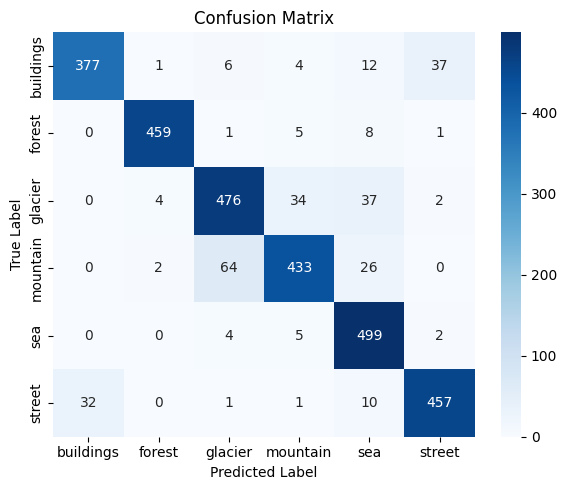


🖼️  预测结果可视化（正确 vs 错误）...


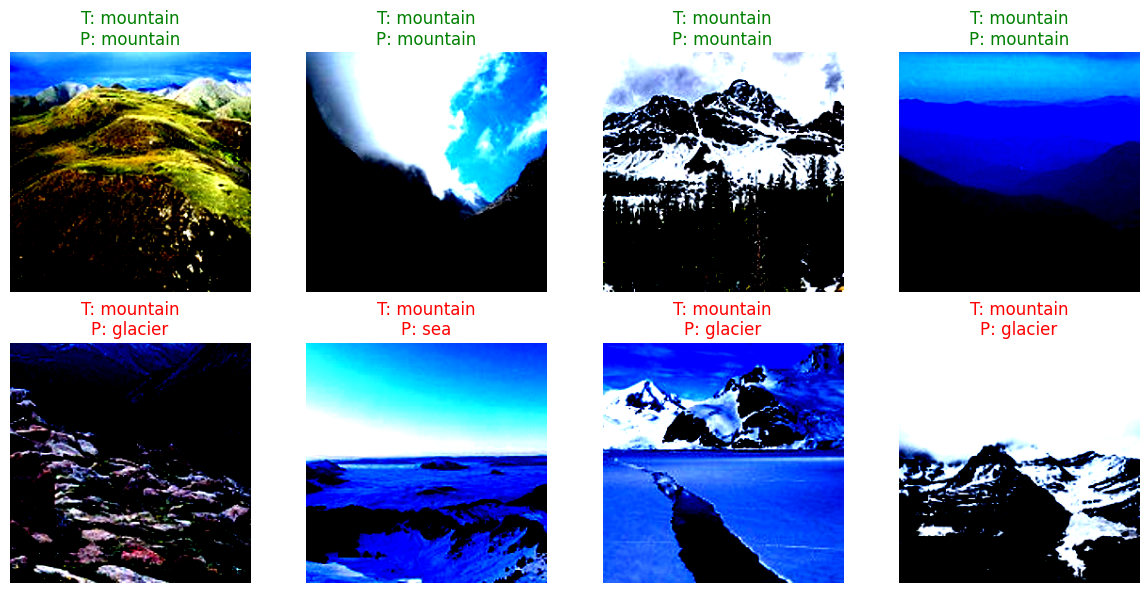

模型评估流程结束


In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

print("=" * 60)
print("开始模型评估流程")
print("=" * 60)

all_preds = []
all_labels = []
all_probs = []
class_names = encoder.classes_
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# 转为 numpy 数组
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# 1. 整体准确率
acc = accuracy_score(all_labels, all_preds)
print(f"\n✅ 验证集整体准确率 (Accuracy): {acc:.4f} ({acc*100:.2f}%)")

# 2. 详细分类报告
print("\n📋 分类报告 (Classification Report):")
report = classification_report(all_labels, all_preds, target_names=class_names, digits=4)
print(report)

# 3. 混淆矩阵
cm = confusion_matrix(all_labels, all_preds)
print("🧮 混淆矩阵 (Confusion Matrix):")
print(cm)

# 可视化混淆矩阵
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# 4. 可视化部分预测结果（正确与错误各若干）
print("\n🖼️  预测结果可视化（正确 vs 错误）...")

# 获取部分原始数据用于可视化（需重新遍历或提前保存）
# 这里假设 val_loader 可重复（或使用 Subset），否则建议在评估前缓存少量样本
def visualize_predictions(model, val_loader, class_names, num_show=4):
    model.eval()
    fig, axes = plt.subplots(2, num_show, figsize=(3*num_show, 6))
    correct_count = 0
    error_count = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            for i in range(images.size(0)):
                img = images[i].cpu().permute(1, 2, 0).numpy()
                # 反归一化（若训练时做了归一化）
                # img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
                img = np.clip(img, 0, 1)
                
                true_label = class_names[labels[i].item()]
                pred_label = class_names[preds[i].item()]
                
                if correct_count < num_show and preds[i] == labels[i]:
                    ax = axes[0, correct_count]
                    ax.imshow(img)
                    ax.set_title(f'T: {true_label}\nP: {pred_label}', color='green')
                    ax.axis('off')
                    correct_count += 1
                
                if error_count < num_show and preds[i] != labels[i]:
                    ax = axes[1, error_count]
                    ax.imshow(img)
                    ax.set_title(f'T: {true_label}\nP: {pred_label}', color='red')
                    ax.axis('off')
                    error_count += 1
                
                if correct_count >= num_show and error_count >= num_show:
                    plt.tight_layout()
                    plt.show()
                    return

# 调用可视化（注意：若 val_loader 有 shuffle=True，每次结果不同）
visualize_predictions(model, val_loader, class_names, num_show=4)

print("=" * 60)
print("模型评估流程结束")
print("=" * 60)

## 1.10 模型导入及预测


In [17]:
# 保存参数导入需要重新建整个模型
model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=len(set(image_labels)))
model.load_state_dict(torch.load(f"/kaggle/working/model_{best_acc}.pt"))
model.cpu()
model.eval()
# 保存全量模型不需要创建模型
best_model = torch.load("/kaggle/working/last.pt", weights_only=False)
best_model.cpu()
best_model.eval()

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2

In [18]:
# 在测试集上进行预测
target_image = "/kaggle/input/intel-image-classification/seg_pred/seg_pred/10004.jpg"
# 使用验证集上相同的预处理步骤
img = Image.open(target_image).convert('RGB')        
img = val_set_transform(img)
print(img.shape)

torch.Size([3, 256, 256])


In [19]:
# 使用tensor对图像第一维多加一个维度
processed_img = img.unsqueeze(0)
# 模型推理
with torch.no_grad():
    output1 = model(processed_img)
    output2 = best_model(processed_img)
    predict1 = torch.argmax(output1).item()
    predict2 = torch.argmax(output2).item()
print("通过参数加载的模型预测结果： ", encoder.inverse_transform([predict1]))
print("通过参数加载的模型预测结果： ", encoder.inverse_transform([predict2]))

通过参数加载的模型预测结果：  ['street']
通过参数加载的模型预测结果：  ['street']
